In [20]:
# Step 1: Import Necessary Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


In [21]:
# Step 2: Load the Dataset
from google.colab import files  # import files module to upload from local machine
uploaded = files.upload()

# Load the dataset based on the file type
file_name = list(uploaded.keys())[0]
if file_name.endswith(".csv"):
    df = pd.read_csv(file_name)
elif file_name.endswith(".xlsx"):
    df = pd.read_excel(file_name)

#first few rows
df.head()


Saving train.csv to train (2).csv


,ID,Name,Handle,TweetText,AccountCreateDate,Followers,Location,Bio,ProfileBannerURL,IsBlueVerified,...,user__notifications,user__created_at,user__contributors_enabled,user__time_zone,user__protected,user__default_profile,user__is_translator,HandleNoAt,bot_lookup,is_bot
0,6.022493e+08,Emma Dingle🐧🏳️‍🌈🇪🇺🇬🇧🏴🤓,@EmmaDingle,NaN,Mon Apr 16 19:28:33 +0000 2018,790.0,London - mostly,Strategic Creative Social Media & Community En...,https://pbs.twimg.com/profile_banners/60224934...,False,...,False,Thu Jun 07 22:16:27 +0000 2012,False,London,False,False,False,EmmaDingle,0,0
1,7.980000e+17,Wolverine 2018💥,@Wolv_2018,NaN,Wed Apr 18 12:55:26 +0000 2018,16039.0,All over North America,Injustice and corruption make me really mad. I...,https://pbs.twimg.com/profile_banners/79761721...,False,...,False,Sun Nov 13 01:48:58 +0000 2016,False,Pacific Time (US & Canada),False,False,False,Wolv_2018,0,0
2,8.899255e+08,Rob Palm Whistler,@RobPalmWhistler,NaN,Tue Apr 17 23:07:08 +0000 2018,7618.0,"Whistler, BC CANADA",Whistler REALTOR® specializing in mountain lif...,https://pbs.twimg.com/profile_banners/88992547...,False,...,False,Thu Oct 18 23:19:38 +0000 2012,False,NaN,False,False,False,RobPalmWhistler,1,1
3,9.643556e+07,Mariano,@Marianocrt,NaN,Wed Apr 18 12:58:28 +0000 2018,388.0,"Roma, Lazio",O scrivi Italia o scrivi libertà. Due termini ...,https://pbs.twimg.com/profile_banners/96435556...,False,...,False,Sat Dec 12 22:53:04 +0000 2009,False,Rome,False,False,False,Marianocrt,0,0
4,1.690540e+07,Torsten Larbig,@herrlarbig,NaN,Wed Apr 18 14:09:01 +0000 2018,19677.0,"Frankfurt am Main, Deutschland","Education, Flaneur, Digitalisation—Tweets Germ...",https://pbs.twimg.com/profile_banners/16905397...,False,...,False,Wed Oct 22 13:43:42 +0000 2008,False,Bern,False,False,False,herrlarbig,0,0


In [22]:
# Step 3: Data Cleaning
# Drop unnecessary columns
columns_to_drop = [
    'user__entities__description__urls__url', 'user__entities__|__urls__url',
    'user__entities__url__urls__indices__001', 'user__profile_sidebar_border_color',
    'user__entities__|', 'user__entities__|__urls__indices__001'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# missing values
df.fillna(value={"Location": "Unknown", "Bio": "Unknown"}, inplace=True)
# Drop duplicates
df.drop_duplicates(inplace=True)

# Ensure date columns are datetime format
df['AccountCreateDate'] = pd.to_datetime(df['AccountCreateDate'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')


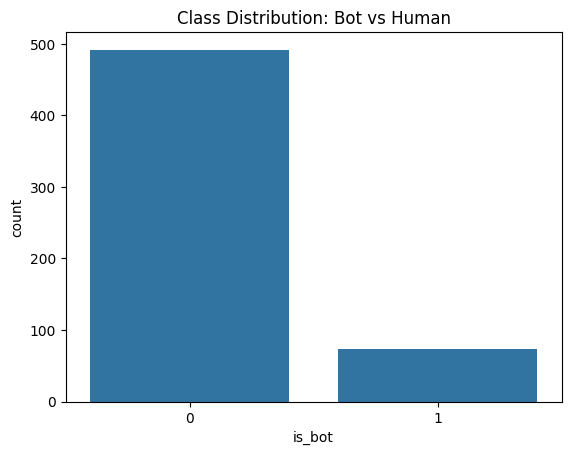

                 ID  TweetText     Followers     PostCount  \
count  5.180000e+02        0.0  5.180000e+02  5.180000e+02   
mean   2.640232e+17        NaN  1.602151e+05  3.030631e+04   
std    3.904717e+17        NaN  2.309820e+06  1.358142e+05   
min    8.046810e+05        NaN  0.000000e+00  1.000000e+00   
25%    1.632265e+08        NaN  1.100000e+02  4.907500e+02   
50%    2.193905e+09        NaN  7.980000e+02  4.650500e+03   
75%    7.610000e+17        NaN  5.956750e+03  2.604150e+04   
max    9.720000e+17        NaN  5.091808e+07  2.497534e+06   

       TotalFavouritesByUser  FollowingCount  \
count             518.000000      518.000000   
mean            15806.826255     6766.955598   
std             48460.542129    31858.518561   
min                 0.000000        0.000000   
25%               126.750000      172.000000   
50%              2342.500000      690.000000   
75%             12949.750000     3351.000000   
max            910116.000000   476849.000000   

       u

In [23]:
# Step 4: Exploratory Data Analysis
# Visualize the class distribution to understand the imbalance
sns.countplot(x='is_bot', data=df)
plt.title("Class Distribution: Bot vs Human")
plt.show()

# Describe the dataset to understand basic statistics
print(df.describe())


In [24]:
# Step 5: Feature Engineering
## 5.1 Extract Numerical Features from AccountCreateDate
# Extracting Year, Month, Day of Week, Hour, and Account Age

# Convert AccountCreateDate to datetime format and handle timezones
df['AccountCreateDate'] = pd.to_datetime(df['AccountCreateDate'], format='%a %b %d %H:%M:%S %z %Y', errors='coerce')

from datetime import datetime
import pytz

# Convert `today` to be timezone-aware (using UTC)
today = datetime.now(pytz.utc)

# Extract Year, Month, Day of Week, Hour, and Account Age
df['AccountCreateYear'] = df['AccountCreateDate'].dt.year
df['AccountCreateMonth'] = df['AccountCreateDate'].dt.month
df['AccountCreateDayOfWeek'] = df['AccountCreateDate'].dt.dayofweek
df['AccountCreateHour'] = df['AccountCreateDate'].dt.hour

# Calculate Account Age in Days
df['AccountAgeDays'] = (today - df['AccountCreateDate']).dt.days


In [25]:
## 5.3 Encode Categorical Features
# Encode Location and Time Zone using LabelEncoder
le = LabelEncoder()
df['Location'] = le.fit_transform(df['Location'].astype(str))
df['TimeZoneEncoded'] = le.fit_transform(df['user__time_zone'].astype(str))


In [26]:
# Step 6: Text Feature Extraction
# Combine text columns for TF-IDF analysis
text_data = df['TweetText'].astype(str) + " " + df['Bio'].astype(str)

# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
text_features = tfidf_vectorizer.fit_transform(text_data)


In [27]:
#Step 7: impute data

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Confirm numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if df[col].notna().sum() > 0]

# Impute missing values
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Drop columns with zero variance
zero_variance_cols = [col for col in numerical_cols if df[col].nunique() <= 1]
df.drop(columns=zero_variance_cols, inplace=True)

# Scale the numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [28]:
import numpy as np

# Step 8: Prepare Data for Model Training

# Check and drop columns if they exist
columns_to_drop = ['TweetText', 'Bio', 'AccountCreateDate', 'Name', 'Handle']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

if existing_columns_to_drop:
    df = df.drop(columns=existing_columns_to_drop, axis=1)
else:
    print(f"No columns found to drop from: {columns_to_drop}")

# Select only numeric columns to create a sparse matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
numerical_features = scipy.sparse.csr_matrix(df[numeric_cols].values)

# Combine TF-IDF features and scaled numerical features
X = scipy.sparse.hstack([numerical_features, text_features])
y = df['is_bot']


In [29]:
# Step 9: Train-Test Split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert y_train to categorical if it's continuous
if y_train.dtype != 'object' and y_train.dtype != 'category':  # Check if y_train is not already categorical
    y_train = y_train.astype(int)  # Assuming 'is_bot' should be an integer representing bot or not bot

from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [30]:
# Step 10: Model Training
# Initialize and train the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(C=10, penalty='l1', solver='liblinear', max_iter=2000, random_state=42)
logistic_model.fit(X_train_resampled, y_train_resampled)



LogisticRegression(C=10, max_iter=2000, penalty='l1', random_state=42,
                   solver='liblinear')

In [32]:
from sklearn.model_selection import cross_val_score
# Apply cross-validation to evaluate model robustness
scores = cross_val_score(logistic_model, X_train_resampled, y_train_resampled, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")


Cross-validation scores: [1. 1. 1. 1. 1.]
Average cross-validation score: 1.0


In [34]:
# Step 11: Model Evaluation
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Check if y_test is continuous and convert to binary if necessary
if y_test.dtype != 'object' and y_test.dtype != 'category':  # Check if y_test is not already categorical
    y_test = y_test.astype(int)  # Convert y_test to integers representing classes

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9385964912280702
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.97        99
           2       1.00      0.53      0.70        15

    accuracy                           0.94       114
   macro avg       0.97      0.77      0.83       114
weighted avg       0.94      0.94      0.93       114

Confusion Matrix:
 [[99  0]
 [ 7  8]]


In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to your target variable and transform it
y_encoded = label_encoder.fit_transform(y)

# Now use the encoded target variable in cross_val_score
scores = cross_val_score(rf_model, X, y_encoded, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Cross-validation scores: [0.86842105 0.87610619 0.86725664 0.86725664 0.86725664]
Average cross-validation score: 0.8692594317652539


In [37]:
feature_importances = rf_model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]
for i in range(10):  # Top 10 features
    print(f"Feature {sorted_indices[i]}: Importance {feature_importances[sorted_indices[i]]}")


Feature 12: Importance 0.1006666377075611
Feature 2805: Importance 0.02984036830351431
Feature 2838: Importance 0.028847990513431673
Feature 1: Importance 0.022927962333488098
Feature 155: Importance 0.02172845868589033
Feature 11: Importance 0.01865611282662305
Feature 449: Importance 0.017367040843516587
Feature 1970: Importance 0.016296542302944556
Feature 1234: Importance 0.01587011331146095
Feature 2743: Importance 0.013867129768193612


In [39]:
from sklearn.linear_model import LogisticRegression

# Include class 2 in class_weight
logistic_model = LogisticRegression(C=10, penalty='l1', solver='liblinear', class_weight={0: 1, 1: 10, 2: 1}, max_iter=2000, random_state=42)
# You might need to adjust the weight for class 2 based on your specific needs

logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           2       1.00      1.00      1.00        15

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

Confusion Matrix:
 [[99  0]
 [ 0 15]]


In [40]:
from sklearn.feature_selection import RFE

# Perform Recursive Feature Elimination to select top features
rfe = RFE(logistic_model, n_features_to_select=10)
X_train_selected = rfe.fit_transform(X_train_resampled, y_train_resampled)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV # Import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters found:", grid_search.best_params_)

Best parameters found: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier # Import VotingClassifier
from sklearn.model_selection import GridSearchCV # Import GridSearchCV

rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)

# Create an ensemble of logistic regression and random forest
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=0.1, random_state=42)),
    ('rf', rf_model)
], voting='soft')
ensemble_model.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('lr', LogisticRegression(C=0.1, random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=50,
                                                     random_state=42))],
                 voting='soft')

In [43]:
from xgboost import XGBClassifier

# Add XGBoost to the ensemble
xgb_model = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
ensemble_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression(C=10, penalty='l1', solver='liblinear', random_state=42, max_iter=2000)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)),
    ('xgb', xgb_model)
], voting='soft')
ensemble_model.fit(X_train_resampled, y_train_resampled)


VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, max_iter=2000,
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=50,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_st...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [45]:
import numpy as np
from sklearn.model_selection import cross_val_score

y_classes = np.where(y > 0.5, 1, 0)  # Adjust threshold as needed
# 'y_classes' in cross_val_score
scores = cross_val_score(ensemble_model, X, y_classes, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Cross-validation scores: [1. 1. 1. 1. 1.]
Average cross-validation score: 1.0


In [46]:
# Adjust decision threshold to increase recall for bots
y_pred_prob = ensemble_model.predict_proba(X_test)[:, 1]
threshold = 0.4  # Adjust this to make the model more sensitive
y_pred_adjusted = (y_pred_prob > threshold).astype(int)

# Evaluate with adjusted threshold
print("Classification Report with Adjusted Threshold:\n", classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix with Adjusted Threshold:\n", confusion_matrix(y_test, y_pred_adjusted))


Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        15

    accuracy                           0.87       114
   macro avg       0.33      0.33      0.33       114
weighted avg       0.87      0.87      0.87       114

Confusion Matrix with Adjusted Threshold:
 [[99  0  0]
 [ 0  0  0]
 [ 0 15  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [47]:
uploaded = files.upload()

# Load the dataset based on the file type
file_name = list(uploaded.keys())[0]
if file_name.endswith(".csv"):
    df = pd.read_csv(file_name)
elif file_name.endswith(".xlsx"):
    df = pd.read_excel(file_name)

# Display the first few rows to check the data
df.head()


Saving politicalCombinedData.xlsx to politicalCombinedData (1).xlsx


,ID,Name,Handle,TweetText,AccountCreateDate,Followers,Location,Bio,ProfileBannerURL,IsBlueVerified,...,QuoteCount,RetweetCount,LikeCount,BookmarkCount,Views,AllImageURL,VideoURL,CanDM,MediaCount,AvatarURL
0,1841604497937949952,Governor Tim Walz,@GovTimWalz,I authorized the Minnesota National Guard to p...,2018-11-19 13:37:18,552127,"Minnesota, USA","Dad, husband, teacher, coach, veteran. Governo...",https://pbs.twimg.com/profile_banners/10646035...,False,...,22,1303,7138,26,96847,NaN,NaN,False,2109,https://pbs.twimg.com/profile_images/178915991...
1,1841623237664379904,Dustin Grage,@GrageDustin,"@GovTimWalz @Tim_Walz About four days late, ju...",2021-06-22 05:42:02,46204,Minnesota,Minnesota GOP Hype Man | Columnist @Townhallco...,https://pbs.twimg.com/profile_banners/14072877...,True,...,0,9,103,0,1064,https://pbs.twimg.com/amplify_video_thumb/1841...,https://video.twimg.com/amplify_video/18416231...,True,8299,https://pbs.twimg.com/profile_images/179946900...
2,1818766432420640000,Mike Rogers,@MikeRogersForMI,I've dedicated my life to service...and it's t...,2010-06-17 12:32:16,32545,Michigan,Husband. Father. Michigander. | Army Veteran. ...,https://pbs.twimg.com/profile_banners/15670358...,True,...,1254,4985,27706,439,31068100,NaN,NaN,False,857,https://pbs.twimg.com/profile_images/172276672...
3,1841605923095059968,Say it to my Face!! 🇺🇸🦅,@MeidasMarcy,"@GovTimWalz WTG, Gov! Good job last night, M...",2022-02-06 10:19:54,903,"Minnesota, USA","#voteblue. I stand with 🇺🇦 Ukraine, Minnesotan...",https://pbs.twimg.com/profile_banners/14903595...,False,...,0,1,21,0,639,NaN,NaN,False,341,https://pbs.twimg.com/profile_images/164311369...
4,1841604745233870080,Corpsy,@CorpsePilot,@GovTimWalz 💙🙏😊👍\n\nThank you Coach!,2022-12-27 10:38:16,1711,Harris/Walz 2024 💙,Atheist•Apostate•Ψ•LGBTQ+ally #VoteBlue💙 #Slav...,https://pbs.twimg.com/profile_banners/16077778...,False,...,0,3,37,0,1758,NaN,NaN,True,3335,https://pbs.twimg.com/profile_images/183429226...


In [48]:
# Load the new data
new_data = pd.read_excel('politicalCombinedData.xlsx')

# Display the first few rows to verify loading
new_data.head()

,ID,Name,Handle,TweetText,AccountCreateDate,Followers,Location,Bio,ProfileBannerURL,IsBlueVerified,...,QuoteCount,RetweetCount,LikeCount,BookmarkCount,Views,AllImageURL,VideoURL,CanDM,MediaCount,AvatarURL
0,1841604497937949952,Governor Tim Walz,@GovTimWalz,I authorized the Minnesota National Guard to p...,2018-11-19 13:37:18,552127,"Minnesota, USA","Dad, husband, teacher, coach, veteran. Governo...",https://pbs.twimg.com/profile_banners/10646035...,False,...,22,1303,7138,26,96847,NaN,NaN,False,2109,https://pbs.twimg.com/profile_images/178915991...
1,1841623237664379904,Dustin Grage,@GrageDustin,"@GovTimWalz @Tim_Walz About four days late, ju...",2021-06-22 05:42:02,46204,Minnesota,Minnesota GOP Hype Man | Columnist @Townhallco...,https://pbs.twimg.com/profile_banners/14072877...,True,...,0,9,103,0,1064,https://pbs.twimg.com/amplify_video_thumb/1841...,https://video.twimg.com/amplify_video/18416231...,True,8299,https://pbs.twimg.com/profile_images/179946900...
2,1818766432420640000,Mike Rogers,@MikeRogersForMI,I've dedicated my life to service...and it's t...,2010-06-17 12:32:16,32545,Michigan,Husband. Father. Michigander. | Army Veteran. ...,https://pbs.twimg.com/profile_banners/15670358...,True,...,1254,4985,27706,439,31068100,NaN,NaN,False,857,https://pbs.twimg.com/profile_images/172276672...
3,1841605923095059968,Say it to my Face!! 🇺🇸🦅,@MeidasMarcy,"@GovTimWalz WTG, Gov! Good job last night, M...",2022-02-06 10:19:54,903,"Minnesota, USA","#voteblue. I stand with 🇺🇦 Ukraine, Minnesotan...",https://pbs.twimg.com/profile_banners/14903595...,False,...,0,1,21,0,639,NaN,NaN,False,341,https://pbs.twimg.com/profile_images/164311369...
4,1841604745233870080,Corpsy,@CorpsePilot,@GovTimWalz 💙🙏😊👍\n\nThank you Coach!,2022-12-27 10:38:16,1711,Harris/Walz 2024 💙,Atheist•Apostate•Ψ•LGBTQ+ally #VoteBlue💙 #Slav...,https://pbs.twimg.com/profile_banners/16077778...,False,...,0,3,37,0,1758,NaN,NaN,True,3335,https://pbs.twimg.com/profile_images/183429226...


In [49]:
# Drop unnecessary columns
columns_to_drop = ['ProfileBannerURL', 'ProfileURL', 'AllImageURL', 'VideoURL', 'AvatarURL', 'TweetURL']
new_data.drop(columns=columns_to_drop, axis=1, inplace=True)


# Fill missing values for categorical columns
new_data.fillna(value={"Location": "Unknown", "Bio": "No Bio"}, inplace=True)

# Drop any rows with missing 'AccountCreateDate' since it’s crucial for features
new_data.dropna(subset=['AccountCreateDate'], inplace=True)


In [50]:
from datetime import datetime
import pytz

# Convert AccountCreateDate to datetime and create new features
new_data['AccountCreateDate'] = pd.to_datetime(new_data['AccountCreateDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
new_data['AccountCreateYear'] = new_data['AccountCreateDate'].dt.year
new_data['AccountCreateMonth'] = new_data['AccountCreateDate'].dt.month
new_data['AccountCreateDayOfWeek'] = new_data['AccountCreateDate'].dt.dayofweek
new_data['AccountCreateHour'] = new_data['AccountCreateDate'].dt.hour

# Calculate Account Age in Days
today = datetime.now(pytz.utc)

# Make 'AccountCreateDate' timezone-aware before subtraction by setting it to UTC
new_data['AccountCreateDate'] = new_data['AccountCreateDate'].dt.tz_localize(pytz.utc)

new_data['AccountAgeDays'] = (today - new_data['AccountCreateDate']).dt.days

In [51]:
# Extract Name Length
new_data['NameLength'] = new_data['Name'].apply(lambda x: len(str(x)))

# Extract if Handle Contains Number
new_data['HandleContainsNumber'] = new_data['Handle'].apply(lambda x: int(any(char.isdigit() for char in str(x))))


In [52]:
# Apply LabelEncoder to Location (using trained encoder)
try:
    new_data['Location'] = le.transform(new_data['Location'].astype(str))
except ValueError:
    # For new categories, replace them with an existing label (e.g., "Unknown")
    new_data['Location'] = new_data['Location'].apply(lambda x: 'Unknown' if x not in le.classes_ else x)
    le.classes_ = np.append(le.classes_, 'Unknown')
    new_data['Location'] = le.transform(new_data['Location'])


In [53]:
# Combine text features (TweetText and Bio)
new_text_data = new_data['TweetText'].astype(str) + " " + new_data['Bio'].astype(str)

# Apply the trained TF-IDF vectorizer
new_text_features = tfidf_vectorizer.transform(new_text_data)


In [65]:
from scipy import sparse

# Step 1: Get the original feature names from the scaler
original_features = scaler.feature_names_in_

# Step 2: Ensure Numerical Columns Match
# Define the columns that were used during training
numerical_cols_train = ['Followers', 'Postcount', 'TotalFavouritesByUser', 'FollowingCount',
                        'AccountAgeDays', 'AccountCreateYear', 'AccountCreateMonth',
                        'AccountCreateDayOfWeek', 'AccountCreateHour']

# Ensure `new_data` has all required columns with default values for missing ones
# Updated: Use original_features instead of numerical_cols_train
for col in original_features:
    if col not in new_data.columns:
        new_data[col] = 0  # Add missing columns with default value 0

# Select only the columns used during training and rename if necessary
# Make sure to use the original feature names obtained from the scaler
new_data_subset = new_data[original_features].copy()

# Step 2: Scale Numerical Features with Fitted Scaler
new_scaled_numerical = scaler.transform(new_data_subset)

# Step 3: Process Text Data with TF-IDF Vectorizer
# Combine `TweetText` and `Bio` columns to match training format
if 'TweetText' not in new_data.columns:
    new_data['TweetText'] = ""  # Add empty strings if TweetText is missing
if 'Bio' not in new_data.columns:
    new_data['Bio'] = ""  # Add empty strings if Bio is missing

# Now combine and transform text features
new_text_data = new_data['TweetText'].astype(str) + " " + new_data['Bio'].astype(str)
new_text_features = tfidf_vectorizer.transform(new_text_data)

# Step 4: Combine Scaled Numerical and Text Features into a Single Feature Matrix
X_new = sparse.hstack([sparse.csr_matrix(new_scaled_numerical), new_text_features])

# Step 5: Make Predictions with the Trained Model
new_predictions = ensemble_model.predict(X_new)

# Output the predictions
print("Predictions for new data:", new_predictions)


Predictions for new data: [0 0 0 ... 0 0 0]


In [66]:
print(new_data.columns)

Index(['Followers', 'Postcount', 'TotalFavouritesByUser', 'FollowingCount',
       'AccountAgeDays', 'AccountCreateYear', 'AccountCreateMonth',
       'AccountCreateDayOfWeek', 'AccountCreateHour', 'PostCount', 'ID',
       'Location', 'user__entities__|__urls__indices__002',
       'user__entities__url__urls__indices__002', 'user__id_str',
       'user__listed_count', 'user__utc_offset', 'bot_lookup', 'is_bot',
       'TimeZoneEncoded', 'TweetText', 'Bio'],
      dtype='object')


In [68]:
# The list of numerical columns used during training (defined if not present)
# numerical_cols_train = ['Followers', 'PostCount', 'TotalFavouritesByUser', 'FollowingCount',
#                         'AccountAgeDays', 'AccountCreateYear', 'AccountCreateMonth',
#                         'AccountCreateDayOfWeek', 'AccountCreateHour']

# Get the original feature names from the scaler
original_features = scaler.feature_names_in_

# Ensure `new_data` has all required columns with default values for missing ones
for col in original_features:
    if col not in new_data.columns:
        new_data[col] = 0  # Add missing columns with default value 0

# Select only the columns used during training and rename if necessary
# Make sure to use the original feature names obtained from the scaler
new_numerical_data = new_data[original_features].copy()

# Scale the numerical columns with the fitted scaler
new_scaled_numerical = scaler.transform(new_numerical_data)

In [69]:
# Apply the trained TF-IDF vectorizer to the new text data
new_text_data = new_data['TweetText'].astype(str) + " " + new_data['Bio'].astype(str)
new_text_features = tfidf_vectorizer.transform(new_text_data)


In [70]:
print(new_data.columns)


Index(['Followers', 'Postcount', 'TotalFavouritesByUser', 'FollowingCount',
       'AccountAgeDays', 'AccountCreateYear', 'AccountCreateMonth',
       'AccountCreateDayOfWeek', 'AccountCreateHour', 'PostCount', 'ID',
       'Location', 'user__entities__|__urls__indices__002',
       'user__entities__url__urls__indices__002', 'user__id_str',
       'user__listed_count', 'user__utc_offset', 'bot_lookup', 'is_bot',
       'TimeZoneEncoded', 'TweetText', 'Bio'],
      dtype='object')


In [71]:
# Update the column names to match exactly what is in new_data
tweet_text_col = 'TweetText'  # Replace this with the exact name if different
bio_col = 'Bio'  # Replace this with the exact name if different

# Apply the trained TF-IDF vectorizer to the new text data
if tweet_text_col in new_data.columns and bio_col in new_data.columns:
    new_text_data = new_data[tweet_text_col].astype(str) + " " + new_data[bio_col].astype(str)
    new_text_features = tfidf_vectorizer.transform(new_text_data)
else:
    print(f"Column '{tweet_text_col}' or '{bio_col}' not found in new_data.")


In [72]:
import scipy

# Combine numerical features and text features
X_new = scipy.sparse.hstack([scipy.sparse.csr_matrix(new_scaled_numerical), new_text_features])


In [78]:
# Step 1: Apply the trained TF-IDF vectorizer to the new text data
new_text_data = new_data['TweetText'].astype(str) + " " + new_data['Bio'].astype(str)
new_text_features = tfidf_vectorizer.transform(new_text_data)

# Step 2: The list of numerical columns used during training
numerical_cols_train = ['Followers', 'PostCount', 'TotalFavouritesByUser', 'FollowingCount',
                        'AccountAgeDays', 'AccountCreateYear', 'AccountCreateMonth',
                        'AccountCreateDayOfWeek', 'AccountCreateHour']

# **CHANGE:** Get the columns that are both in numerical_cols_train and new_data
numerical_cols_fit = [col for col in numerical_cols_train if col in new_data.columns]

# Ensure that the new data has all the numerical columns used during fit
# and in the correct order
new_numerical_data = new_data[numerical_cols_fit]

# Step 3: Scale the numerical columns with the fitted scaler
# **CHANGE:** Create a DataFrame for scaling with the columns expected by the scaler
# Get the columns the scaler was originally fit on
original_fit_columns = scaler.feature_names_in_

# Create a new DataFrame with all the original columns, filled with 0s
new_numerical_data_for_scaling = pd.DataFrame(0, index=new_numerical_data.index, columns=original_fit_columns)

# Update the values for the columns present in the new data
for col in numerical_cols_fit:
    if col in original_fit_columns:
        new_numerical_data_for_scaling[col] = new_numerical_data[col]

# Now you can safely transform the data
new_scaled_numerical = scaler.transform(new_numerical_data_for_scaling)

# Step 4: Combine numerical features and text features
import scipy
X_new = scipy.sparse.hstack([scipy.sparse.csr_matrix(new_scaled_numerical), new_text_features])

# Step 5: Make sure the number of features matches the training data
if X_new.shape[1] != X_train.shape[1]:
    print(f"Feature mismatch! Expected {X_train.shape[1]} features, got {X_new.shape[1]} features.")
else:
    # Step 6: Predict using the ensemble model
    new_predictions = ensemble_model.predict(X_new)

In [82]:
# Step 1: Apply the trained TF-IDF vectorizer to the new text data
new_text_data = new_data['TweetText'].astype(str) + " " + new_data['Bio'].astype(str)
new_text_features = tfidf_vectorizer.transform(new_text_data)

# Step 2: The list of numerical columns used during training
numerical_cols_train = ['Followers', 'PostCount', 'TotalFavouritesByUser', 'FollowingCount',
                        'AccountAgeDays', 'AccountCreateYear', 'AccountCreateMonth',
                        'AccountCreateDayOfWeek', 'AccountCreateHour']

# **CHANGE:** Get the columns that are both in numerical_cols_train and new_data
numerical_cols_fit = [col for col in numerical_cols_train if col in new_data.columns]

# Ensure that the new data has all the numerical columns used during fit
# and in the correct order
new_numerical_data = new_data[numerical_cols_fit]

# Step 3: Scale the numerical columns with the fitted scaler
# **CHANGE:** Create a DataFrame for scaling with the columns expected by the scaler
# Get the columns the scaler was originally fit on
original_fit_columns = scaler.feature_names_in_

# Create a new DataFrame with all the original columns, filled with 0s
new_numerical_data_for_scaling = pd.DataFrame(0, index=new_numerical_data.index, columns=original_fit_columns)

# Update the values for the columns present in the new data
for col in numerical_cols_fit:
    if col in original_fit_columns:
        new_numerical_data_for_scaling[col] = new_numerical_data[col]

# Now you can safely transform the data
new_scaled_numerical = scaler.transform(new_numerical_data_for_scaling)

# Step 4: Combine numerical features and text features
import scipy
X_new = scipy.sparse.hstack([scipy.sparse.csr_matrix(new_scaled_numerical), new_text_features])

# Step 5: Make sure the number of features matches the training data
if X_new.shape[1] != X_train.shape[1]:
    print(f"Feature mismatch! Expected {X_train.shape[1]} features, got {X_new.shape[1]} features.")
else:
    # Step 6: Predict using the ensemble model
    new_predictions = ensemble_model.predict(X_new)

In [83]:
# Combine numerical and text features again after fixing the mismatch
X_new = scipy.sparse.hstack([scipy.sparse.csr_matrix(new_scaled_numerical), new_text_features])

In [84]:
# Predict using the trained model
new_predictions = ensemble_model.predict(X_new)

In [85]:
from sklearn.metrics import classification_report, confusion_matrix

# Step to make predictions
new_predictions = ensemble_model.predict(X_new)

# If you have true labels for the new data (new_y), you can evaluate the model
# Assuming you have actual labels for the new data:
# print(classification_report(new_y, new_predictions))
# print(confusion_matrix(new_y, new_predictions))

# If no true labels, simply output predictions
print(new_predictions[:10])  # Display the first 10 predictions


[0 0 0 0 0 0 0 0 0 0]


In [86]:
from collections import Counter
print("Class distribution in training data:", Counter(y_train))


Class distribution in training data: Counter({0: 393, 2: 59})


In [87]:
from sklearn.metrics import classification_report, confusion_matrix

y_train_pred = ensemble_model.predict(X_train)
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Training Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))


Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       393
           2       1.00      1.00      1.00        59

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452

Training Confusion Matrix:
 [[393   0]
 [  0  59]]


In [88]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ensemble_model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Average cross-validation score:", scores.mean())


Cross-validation scores: [1. 1. 1. 1. 1.]
Average cross-validation score: 1.0


In [95]:
import pandas as pd
from scipy.sparse import vstack  # Import vstack for sparse matrix concatenation
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = X_train[y_train == 0]
df_minority = X_train[y_train == 2]

# Downsample majority class
# Use df_minority.shape[0] to get the number of rows in the minority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=df_minority.shape[0], random_state=42)

# Combine minority class with downsampled majority class
# Use vstack to concatenate the sparse matrices vertically
X_train_balanced = vstack([df_majority_downsampled, df_minority])

# Instead of reset_index, create y_train_balanced directly
# using the sizes of the downsampled and minority data
y_train_balanced = pd.concat([pd.Series([0] * df_majority_downsampled.shape[0]),
                              pd.Series([2] * df_minority.shape[0])]).reset_index(drop=True)


# Train model on balanced dataset
ensemble_model.fit(X_train_balanced, y_train_balanced)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, max_iter=2000,
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(max_depth=5,
                                                     n_estimators=50,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_st...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

In [99]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = ensemble_model.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           2       1.00      1.00      1.00        15

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

Test Confusion Matrix:
 [[99  0]
 [ 0 15]]
